# 🎯 Problema de Negócio Principal:
Como prever o comportamento das ações da VALE3 para apoiar decisões estratégicas de compra e venda? 
Com base em dados históricos de preços e volume, o objetivo é construir um modelo que possa prever o retorno diário(preço da ação para os proximos 7 dias). Isso pode ser usado para:

* Estratégias de trading algorítmico;

* Gestão de risco e identificação de dias anômalos;

* Criação de indicadores preditivos de tendência.

* Importação das bibliotecas necessárias:

In [ ]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import yfinance as yf # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from statsmodels.tsa.statespace.sarimax import SARIMAX # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from xgboost import XGBRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error # type: ignore
import warnings
warnings.filterwarnings('ignore')

# 1. Coletando e tratando os dados. 

In [2]:
# Baixando os preços históricos da VALE3:
df_Vale = yf.download(tickers='VALE3.SA', start='2022-01-01', end='2025-08-01', multi_level_index=False)
df_Vale = df_Vale[['Close', 'Open', 'Volume']]
df_Vale.reset_index(inplace=True)
df_Vale['Date'] = pd.to_datetime(df_Vale['Date'])
df_Vale.set_index('Date', inplace=True)
df_Vale.rename(columns={
    'Close': 'Close_VALE3',
    'Open': 'Open_VALE3',
    'Volume': 'Volume_VALE3'
}, inplace=True)

# Baixando os preços históricos do minério de ferro:
df_ferro = pd.read_csv("Dados Históricos - Minério de ferro refinado 62% Fe CFR Futuros.csv")
df_ferro.reset_index(inplace=True)
df_ferro['Data'] = pd.to_datetime(df_ferro['Data'], dayfirst=True)
df_ferro.set_index('Data', inplace=True)
df_ferro = df_ferro[['Último','Abertura', 'Var%']]
# Invertendo a ordem das datas:
df_ferro = df_ferro.sort_index(ascending=True)
df_ferro.rename(columns={
    'Último': 'Close_Ferro',
    'Abertura': 'Open_Ferro',
    'Var%': 'Variacao_ferro'
}, inplace=True) 

# Agora vamos unir os dataframes:

df = pd.merge(df_Vale, df_ferro, left_index=True, right_index=True, suffixes=('_VALE3', '_Ferro'))

# Variação percentual do preço de fechamento da VALE3:
df['Variação_VALE3'] = df_Vale['Close_VALE3'].pct_change() * 100
# Trocando nan por 0%:
df['Variação_VALE3'].fillna(0, inplace=True)

# Vamos transformar as colunas Close_Minerio, Open_Minerio e Variação_Minerio em float:
df['Close_Ferro'] = df['Close_Ferro'].str.replace(',', '.', regex=False).astype(float)
df['Open_Ferro'] = df['Open_Ferro'].str.replace(',', '.', regex=False).astype(float)
df['Variacao_ferro'] = df['Variacao_ferro'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Tratamento para transforma o index em datetime após o merge:
df.reset_index(inplace=True)
df['index'] = pd.to_datetime(df['index'], dayfirst=True)
df.rename(columns={'index': 'Data'}, inplace=True)
df.set_index('Data', inplace=True)

df

[*********************100%***********************]  1 of 1 completed


,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Ferro,Open_Ferro,Variacao_ferro,Variação_VALE3
Data,,,,,,,
2022-01-03,57.766418,58.507014,18557200,120.40,120.40,7.02,0.000000
2022-01-04,57.085068,58.144119,18178700,120.91,120.91,0.42,-1.179493
2022-01-05,57.625694,57.299836,22039000,124.14,124.14,2.67,0.947054
2022-01-06,58.788433,58.240394,22044100,125.94,125.94,1.45,2.017744
2022-01-07,62.209988,59.543846,35213100,126.21,126.21,0.21,5.820115
...,...,...,...,...,...,...,...
2025-07-25,55.700001,56.180000,21918900,98.55,98.55,-0.03,-1.468243
2025-07-28,55.160000,54.939999,19175100,98.67,98.67,0.12,-0.969481
2025-07-29,54.820000,55.549999,14648700,98.98,98.98,0.31,-0.616389


# 2. Adicionando features no nosso DataFrame.

* Médias móveis de 7 dias, 20 dias e 200 dias para suavizar as oscilações de preços e identificar tendências de forma mais clara:

In [3]:
janelas = [7,20,200]

for janela in janelas:
    df[f'MM_{janela}D'] = df['Close_VALE3'].rolling(window=janela, min_periods=1).mean()

df[['MM_7D', 'MM_20D', 'MM_200D']]

,MM_7D,MM_20D,MM_200D
Data,,,
2022-01-03,57.766418,57.766418,57.766418
2022-01-04,57.425743,57.425743,57.425743
2022-01-05,57.492393,57.492393,57.492393
2022-01-06,57.816403,57.816403,57.816403
2022-01-07,58.695120,58.695120,58.695120
...,...,...,...
2025-07-25,56.008571,54.962000,54.664099
2025-07-28,56.131428,55.076500,54.650813
2025-07-29,56.168571,55.185000,54.618465


* Vamos adicionar o retorno diário, e os retornos de sete dias anteriores e 21 dias anteriores:

In [4]:
retornos = [1,7,21]

for retorno in retornos:
    df[f'Retorno_{retorno}D'] = df['Close_VALE3'].pct_change(retorno) * 100
    df[f'Retorno_{retorno}D'].fillna(0, inplace=True)

df[['Retorno_1D', 'Retorno_7D', 'Retorno_21D']]

,Retorno_1D,Retorno_7D,Retorno_21D
Data,,,
2022-01-03,0.000000,0.000000,0.000000
2022-01-04,-1.179493,0.000000,0.000000
2022-01-05,0.947054,0.000000,0.000000
2022-01-06,2.017744,0.000000,0.000000
2022-01-07,5.820115,0.000000,0.000000
...,...,...,...
2025-07-25,-1.468243,2.389704,10.340732
2025-07-28,-0.969481,1.583795,6.076923
2025-07-29,-0.616389,0.476537,3.688294


* Relative Strength Index(14 dias). Um indicador usado para avaliar a força de um movimento
de preço e determinar se um ativo está sobrecarregado ou sobrevendido:

In [5]:
def calcular_RSI(series, windows=14):
    delta = series.diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_again = gain.rolling(window=windows).mean()
    avg_loss = loss.rolling(window=windows).mean()

    rs = avg_again / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI_14'] = calcular_RSI(df['Close_VALE3'], windows=14)
df['RSI_14'].fillna(df['RSI_14'].mean(), inplace=True)

* O Moving Average Convergence Divergence ajuda a identificar mudanças na força, direção, momento e duração de uma tendência de ações:

In [6]:
MME_12 = df['Close_VALE3'].ewm(span=12, adjust=False).mean()
MME_26 = df['Close_VALE3'].ewm(span=26, adjust=False).mean()

df['MACD'] = MME_12 - MME_26

df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

* As bandas de Bollinger são indicadores usados para medir a volatilidade do mercado e identificar potenciais pontos de compra e venda de ativos: 

In [7]:
# primeiro pegamos as medias móveis de 20 dias:
medias_20D = df['MM_20D']
# E o desvio padrão de 20 dias também:
desvio_20D = df['Close_VALE3'].rolling(window=20, min_periods=1).std()

# Assim podemos calcular as bandas:
df['banda_media'] = medias_20D
df['banda_superior'] = medias_20D + (2 * desvio_20D)
df['banda_inferior'] = medias_20D - (2 * desvio_20D)

# Vamos completar os valores NaN com a média dos dados para cada coluna:
df['banda_inferior'].fillna(df['banda_inferior'].mean(), inplace=True)
df['banda_superior'].fillna(df['banda_superior'].mean(), inplace=True)
df[['banda_media', 'banda_superior', 'banda_inferior']]

,banda_media,banda_superior,banda_inferior
Data,,,
2022-01-03,57.766418,63.262468,55.793055
2022-01-04,57.425743,58.389319,56.462168
2022-01-05,57.492393,58.211800,56.772987
2022-01-06,57.816403,59.239340,56.393467
2022-01-07,58.695120,62.813546,54.576695
...,...,...,...
2025-07-25,54.962000,57.628016,52.295984
2025-07-28,55.076500,57.554268,52.598733
2025-07-29,55.185000,57.390461,52.979539


* O Rolling Sharpe Ratio, ou Razão de Sharpe Móvel, é usado para avaliar o desempenho de um investimento ao longo do tempo, ajustado ao risco:  

In [8]:
def Rolling_Sharpe_Ratio(returns, window=21, risk_free_rate=0.0, trading_days=252):
    # Converter taxa livre de risco para diária:
    rf_daily = (1 + risk_free_rate)**(1/trading_days) - 1

    # Calcular retornos excedentes:
    excess_return = returns - rf_daily

    # Média móvel dos retornos excedentes:
    mean_returns = excess_return.rolling(window).mean()

    # Desvio padrão móvel dos retornos excedentes:
    std_returns = excess_return.rolling(window).std()

    # Sharpe Ratio anualizado:
    sharpe_ratio = mean_returns / std_returns * np.sqrt(trading_days)

    return sharpe_ratio

# Calculando o sharpe ratio de 21 dias( 21 dias = 1 mês de trading):
df['Sharpe_21D'] = Rolling_Sharpe_Ratio(
    returns=df['Retorno_1D'],
    window=21,
    risk_free_rate= 0.15, # 15% ao ano (SELIC atual)
    trading_days=252
)

In [9]:
# Tratando valores NaN do sharpe de 21 dias:
df['Sharpe_21D'].fillna(0, inplace=True)
df['Sharpe_21D'].isnull().sum()

0

* Vamos adicionar a volatilidade de 7 dias e 21 dias:

In [10]:
df['Volatilidade_7D_VALE3'] = np.std(df['Retorno_7D'])
df['Volatilidadde_21D_VALE3'] = np.std(df['Retorno_21D'])
df['Volatilidade_7D_VALE3'].fillna(0, inplace=True)
df['Volatilidadde_21D_VALE3'].fillna(0, inplace=True)

# 3. Normalização, Engenharia de Recursos e Seleção de Recursos.

* 3.1 Vamos normalizar as variáveis que tem escalas muito diferentes, nesse caso ['Close_Ferro', 'Volume_VALE3', 'Volatilidade_7D_VALE3', 'MACD'] serão as variáveis selecionadas.

* Porque não normalizar as demais variáveis ?:
    * Preços absolutos (ex: Close_VALE3, MM_200D):
     
        Se você normalizar os preços, perderá a interpretabilidade direta das previsões (ex: um valor previsto de "1.2" não terá significado em R$).

        Modelos como SARIMA e LSTM trabalham melhor com valores originais em séries temporais financeiras.

    * Indicadores já normalizados (ex: RSI_14, Sharpe_21D):

        O RSI varia entre 0-100 por construção.

        O Sharpe Ratio já é uma métrica padronizada.

In [11]:
# Variáveis que precisam ser normalizadas:
cols_to_scale = ['Close_Ferro', 'Volume_VALE3', 'Volatilidade_7D_VALE3', 'MACD', 'Volatilidadde_21D_VALE3']

scaler = StandardScaler()

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

* Após a normalização os dados são transformados para ter Média = 0 e Desvio Padrão = 1.

1. Close_Ferro:
    2022-01-03: 0.389

    O preço do minério estava 0.39 desvios padrão acima da média histórica.

    2025-07-25: -0.971

    Quase 1 desvio padrão abaixo da média, indicando queda acentuada.

2. Volume_VALE3
    2022-01-03: -0.624

    Volume de negociação 62.4% abaixo da média.

    2022-01-07: 0.630

    Volume 63% acima da média (dia movimentado).

3. Volatilidade_7D_VALE3
    Todos os valores 0.0

    Sugere que a volatilidade foi constante ou que a padronização não variou.

4. MACD
    2022-01-07: 0.347

    Sinal de momentum positivo (compra).

    2025-07-31: 0.284

    Continua positivo, mas menos intenso.

In [12]:
df[['Close_Ferro', 'Volume_VALE3', 'Volatilidade_7D_VALE3', 'Volatilidadde_21D_VALE3' ,'MACD']]

,Close_Ferro,Volume_VALE3,Volatilidade_7D_VALE3,Volatilidadde_21D_VALE3,MACD
Data,,,,,
2022-01-03,0.388809,-0.623531,-8.881784e-16,-2.664535e-15,0.023054
2022-01-04,0.420539,-0.652010,-8.881784e-16,-2.664535e-15,-0.022450
2022-01-05,0.621496,-0.361546,-8.881784e-16,-2.664535e-15,-0.021477
2022-01-06,0.733484,-0.361162,-8.881784e-16,-2.664535e-15,0.057446
2022-01-07,0.750282,0.629726,-8.881784e-16,-2.664535e-15,0.347397
...,...,...,...,...,...
2025-07-25,-0.970605,-0.370583,-8.881784e-16,-2.664535e-15,0.754540
2025-07-28,-0.963139,-0.577037,-8.881784e-16,-2.664535e-15,0.671157
2025-07-29,-0.943852,-0.917622,-8.881784e-16,-2.664535e-15,0.575736


* 3.2 Vamos analisar a correlação entre as variáveis para a seleção de recursos:

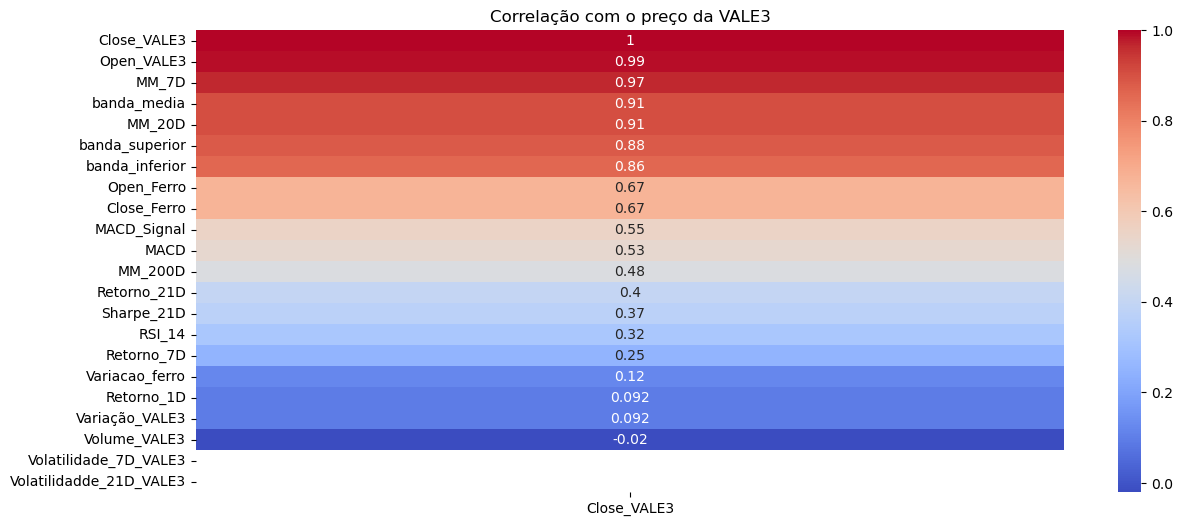

In [13]:
plt.figure(figsize=(14,6))

corr_matriz = df.corr()
sns.heatmap(corr_matriz[['Close_VALE3']].sort_values(by='Close_VALE3', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Correlação com o preço da VALE3')
plt.show()

* Com base na correlação das variáveis com o preço da VALE3, optamos por escolher as seguintes variáveis para o nosso dataframe:

* 1. Close_Ferro:
    Preço do minério de ferro impacta diretamente os resultados da Vale (correlação alta).

* 2. MM_200D:
    Média móvel de 200 dias indica tendência de longo prazo (suporte/resistência).

* 3. banda_superior:
    Limite superior das Bandas de Bollinger → sinal de sobrecompra quando o preço toca.

* 4. banda_inferior:
    Limite inferior das Bandas de Bollinger → sinal de sobrevenda quando o preço toca.

* 5. MACD:
    Indicador de momentum (cruzamentos sinalizam tendências de alta/baixa).

* 6. RSI_14:
    Identifica condições de sobrecompra (>70) ou sobrevenda (<30).

* 7. Retorno_21D:
    Mede o momentum médio prazo (1 mês de trading).

* 8. Sharpe_21D: 
    Avalia risco-retorno (se retornos compensam a volatilidade).

* 9. Volatilidade_7D:
    Risco histórico do ativo.

* 10. Volume_VALE3:
    Liquidez do ativo (volume alto confirma tendências).

* 11. Variacao_Ferro:
    Sensibilidade intradiária da Vale às oscilações do minério.

In [14]:
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Ferro,Open_Ferro,Variacao_ferro,Variação_VALE3,MM_7D,MM_20D,MM_200D,...,Retorno_21D,RSI_14,MACD,MACD_Signal,banda_media,banda_superior,banda_inferior,Sharpe_21D,Volatilidade_7D_VALE3,Volatilidadde_21D_VALE3
Data,,,,,,,,,,,,,,,,,,,,,
2022-01-03,57.766418,58.507014,-0.623531,0.388809,120.40,7.02,0.000000,57.766418,57.766418,57.766418,...,0.000000,49.600134,0.023054,0.000000,57.766418,63.262468,55.793055,0.000000,-8.881784e-16,-2.664535e-15
2022-01-04,57.085068,58.144119,-0.652010,0.420539,120.91,0.42,-1.179493,57.425743,57.425743,57.425743,...,0.000000,49.600134,-0.022450,-0.010871,57.425743,58.389319,56.462168,0.000000,-8.881784e-16,-2.664535e-15
2022-01-05,57.625694,57.299836,-0.361546,0.621496,124.14,2.67,0.947054,57.492393,57.492393,57.492393,...,0.000000,49.600134,-0.021477,-0.019335,57.492393,58.211800,56.772987,0.000000,-8.881784e-16,-2.664535e-15
2022-01-06,58.788433,58.240394,-0.361162,0.733484,125.94,1.45,2.017744,57.816403,57.816403,57.816403,...,0.000000,49.600134,0.057446,-0.007252,57.816403,59.239340,56.393467,0.000000,-8.881784e-16,-2.664535e-15
2022-01-07,62.209988,59.543846,0.629726,0.750282,126.21,0.21,5.820115,58.695120,58.695120,58.695120,...,0.000000,49.600134,0.347397,0.071682,58.695120,62.813546,54.576695,0.000000,-8.881784e-16,-2.664535e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-25,55.700001,56.180000,-0.370583,-0.970605,98.55,-0.03,-1.468243,56.008571,54.962000,54.664099,...,10.340732,56.316300,0.754540,0.706443,54.962000,57.628016,52.295984,4.435949,-8.881784e-16,-2.664535e-15
2025-07-28,55.160000,54.939999,-0.577037,-0.963139,98.67,0.12,-0.969481,56.131428,55.076500,54.650813,...,6.076923,52.705213,0.671157,0.719981,55.076500,57.554268,52.598733,2.817116,-8.881784e-16,-2.664535e-15
2025-07-29,54.820000,55.549999,-0.917622,-0.943852,98.98,0.31,-0.616389,56.168571,55.185000,54.618465,...,3.688294,53.707217,0.575736,0.708016,55.185000,57.390461,52.979539,1.793258,-8.881784e-16,-2.664535e-15


In [15]:
features_selecionadas = df[['Close_Ferro', 'MM_200D', 'banda_superior', 'banda_inferior', 'MACD', 
                           'RSI_14', 'Retorno_21D', 'Sharpe_21D', 'Volatilidade_7D_VALE3', 'Volume_VALE3', 'Variacao_ferro']]
features_selecionadas

,Close_Ferro,MM_200D,banda_superior,banda_inferior,MACD,RSI_14,Retorno_21D,Sharpe_21D,Volatilidade_7D_VALE3,Volume_VALE3,Variacao_ferro
Data,,,,,,,,,,,
2022-01-03,0.388809,57.766418,63.262468,55.793055,0.023054,49.600134,0.000000,0.000000,-8.881784e-16,-0.623531,7.02
2022-01-04,0.420539,57.425743,58.389319,56.462168,-0.022450,49.600134,0.000000,0.000000,-8.881784e-16,-0.652010,0.42
2022-01-05,0.621496,57.492393,58.211800,56.772987,-0.021477,49.600134,0.000000,0.000000,-8.881784e-16,-0.361546,2.67
2022-01-06,0.733484,57.816403,59.239340,56.393467,0.057446,49.600134,0.000000,0.000000,-8.881784e-16,-0.361162,1.45
2022-01-07,0.750282,58.695120,62.813546,54.576695,0.347397,49.600134,0.000000,0.000000,-8.881784e-16,0.629726,0.21
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-25,-0.970605,54.664099,57.628016,52.295984,0.754540,56.316300,10.340732,4.435949,-8.881784e-16,-0.370583,-0.03
2025-07-28,-0.963139,54.650813,57.554268,52.598733,0.671157,52.705213,6.076923,2.817116,-8.881784e-16,-0.577037,0.12
2025-07-29,-0.943852,54.618465,57.390461,52.979539,0.575736,53.707217,3.688294,1.793258,-8.881784e-16,-0.917622,0.31


# 4. Preparação Final dos Dados.

* 4.1 Vamos definir Close_VALE3 como a variável target:

In [16]:
# preço de fechamento de 7 dias no futuro:
df['Target_7D'] = df['Close_VALE3'].shift(-7)

df.dropna(subset=['Target_7D'], inplace=True) # Eliminação dos valores NaN
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Ferro,Open_Ferro,Variacao_ferro,Variação_VALE3,MM_7D,MM_20D,MM_200D,...,RSI_14,MACD,MACD_Signal,banda_media,banda_superior,banda_inferior,Sharpe_21D,Volatilidade_7D_VALE3,Volatilidadde_21D_VALE3,Target_7D
Data,,,,,,,,,,,,,,,,,,,,,
2022-01-03,57.766418,58.507014,-0.623531,0.388809,120.40,7.02,0.000000,57.766418,57.766418,57.766418,...,49.600134,0.023054,0.000000,57.766418,63.262468,55.793055,0.000000,-8.881784e-16,-2.664535e-15,63.320873
2022-01-04,57.085068,58.144119,-0.652010,0.420539,120.91,0.42,-1.179493,57.425743,57.425743,57.425743,...,49.600134,-0.022450,-0.010871,57.425743,58.389319,56.462168,0.000000,-8.881784e-16,-2.664535e-15,62.358109
2022-01-05,57.625694,57.299836,-0.361546,0.621496,124.14,2.67,0.947054,57.492393,57.492393,57.492393,...,49.600134,-0.021477,-0.019335,57.492393,58.211800,56.772987,0.000000,-8.881784e-16,-2.664535e-15,62.721004
2022-01-06,58.788433,58.240394,-0.361162,0.733484,125.94,1.45,2.017744,57.816403,57.816403,57.816403,...,49.600134,0.057446,-0.007252,57.816403,59.239340,56.393467,0.000000,-8.881784e-16,-2.664535e-15,63.920761
2022-01-07,62.209988,59.543846,0.629726,0.750282,126.21,0.21,5.820115,58.695120,58.695120,58.695120,...,49.600134,0.347397,0.071682,58.695120,62.813546,54.576695,0.000000,-8.881784e-16,-2.664535e-15,65.327888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,54.400002,54.099998,-0.033851,-1.063306,97.06,0.58,0.908925,54.795715,53.166000,54.648418,...,67.132878,0.477957,0.377496,53.166000,57.052611,49.279389,1.725636,-8.881784e-16,-2.664535e-15,55.700001
2025-07-17,54.299999,54.400002,-0.495947,-1.055840,97.18,0.12,-0.183828,54.755714,53.310500,54.640896,...,61.477042,0.445501,0.402916,53.310500,57.136646,49.484354,0.482739,-8.881784e-16,-2.664535e-15,55.160000
2025-07-18,54.560001,54.049999,-0.235512,-1.053352,97.22,0.04,0.478825,54.830000,53.476500,54.636009,...,58.979818,0.432622,0.420175,53.476500,57.211407,49.741593,2.894494,-8.881784e-16,-2.664535e-15,54.820000


* 4.2 Eliminção dos vazamentos de dados:

In [17]:
# Deslocar features em 1 dia (usar dados de ontem para prever futuro):
features = [
    'Close_Ferro', 'MM_200D', 'banda_superior', 'banda_inferior', 'MACD', 
    'RSI_14', 'Retorno_21D', 'Sharpe_21D', 'Volatilidade_7D_VALE3', 
    'Volume_VALE3', 'Variacao_ferro'
]

df[features] = df[features].shift(1)
df.dropna(inplace=True)
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Ferro,Open_Ferro,Variacao_ferro,Variação_VALE3,MM_7D,MM_20D,MM_200D,...,RSI_14,MACD,MACD_Signal,banda_media,banda_superior,banda_inferior,Sharpe_21D,Volatilidade_7D_VALE3,Volatilidadde_21D_VALE3,Target_7D
Data,,,,,,,,,,,,,,,,,,,,,
2022-01-04,57.085068,58.144119,-0.623531,0.388809,120.91,7.02,-1.179493,57.425743,57.425743,57.766418,...,49.600134,0.023054,-0.010871,57.425743,63.262468,55.793055,0.000000,-8.881784e-16,-2.664535e-15,62.358109
2022-01-05,57.625694,57.299836,-0.652010,0.420539,124.14,0.42,0.947054,57.492393,57.492393,57.425743,...,49.600134,-0.022450,-0.019335,57.492393,58.389319,56.462168,0.000000,-8.881784e-16,-2.664535e-15,62.721004
2022-01-06,58.788433,58.240394,-0.361546,0.621496,125.94,2.67,2.017744,57.816403,57.816403,57.492393,...,49.600134,-0.021477,-0.007252,57.816403,58.211800,56.772987,0.000000,-8.881784e-16,-2.664535e-15,63.920761
2022-01-07,62.209988,59.543846,-0.361162,0.733484,126.21,1.45,5.820115,58.695120,58.695120,57.816403,...,49.600134,0.057446,0.071682,58.695120,59.239340,56.393467,0.000000,-8.881784e-16,-2.664535e-15,65.327888
2022-01-10,61.469395,61.091690,0.629726,0.750282,124.48,0.21,-1.190473,59.157499,59.157499,58.695120,...,49.600134,0.347397,0.176399,59.157499,62.813546,54.576695,0.000000,-8.881784e-16,-2.664535e-15,64.217003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,54.400002,54.099998,-0.136559,-1.098147,97.06,-0.27,0.908925,54.795715,53.166000,54.655440,...,65.304266,0.504243,0.377496,53.166000,56.994256,49.280744,0.892204,-8.881784e-16,-2.664535e-15,55.700001
2025-07-17,54.299999,54.400002,-0.033851,-1.063306,97.18,0.58,-0.183828,54.755714,53.310500,54.648418,...,67.132878,0.477957,0.402916,53.310500,57.052611,49.279389,1.725636,-8.881784e-16,-2.664535e-15,55.160000
2025-07-18,54.560001,54.049999,-0.495947,-1.055840,97.22,0.12,0.478825,54.830000,53.476500,54.640896,...,61.477042,0.445501,0.420175,53.476500,57.136646,49.484354,0.482739,-8.881784e-16,-2.664535e-15,54.820000


* 4.3 Divisão temporal dos dados:

* dividiremos os dados em:

    * Treino: Janeiro 2022 a Dezembro 2023

    * Validação: Janeiro 2024 a Junho 2024 (para ajuste de hiperparâmetros)

    * Teste: Julho 2024 a Julho 2025 (dados mais recentes, simulando o "futuro")

In [18]:
train = df.loc['2022-01-04':'2023-12-31']
val = df.loc['2024-01-01':'2024-06-30']
test = df.loc['2024-07-01':'2025-07-22']

# Verificando tamanhos
print(f"Treino: {len(train)} dias | Validação: {len(val)} dias | Teste: {len(test)} dias")

Treino: 482 dias | Validação: 120 dias | Teste: 257 dias


In [19]:
X_train, y_train = train.drop(columns=['Target_7D']), train['Target_7D']
X_val, y_val = val.drop(columns=['Target_7D']), val['Target_7D']
X_test, y_test = test.drop(columns=['Target_7D']), test['Target_7D']

# 5. Implementação individual dos modelos SARIMA + XGBoost + LSTM.

* SARIMA:

* Vamos treinar o modelo SARIMA com uma variável exógena, nesse caso, o preço de fechamneto do minério de ferro. Mas antes de implementar, vamos verificar quais variáveis podem ter melhor correlação com a variável Close_Ferro:

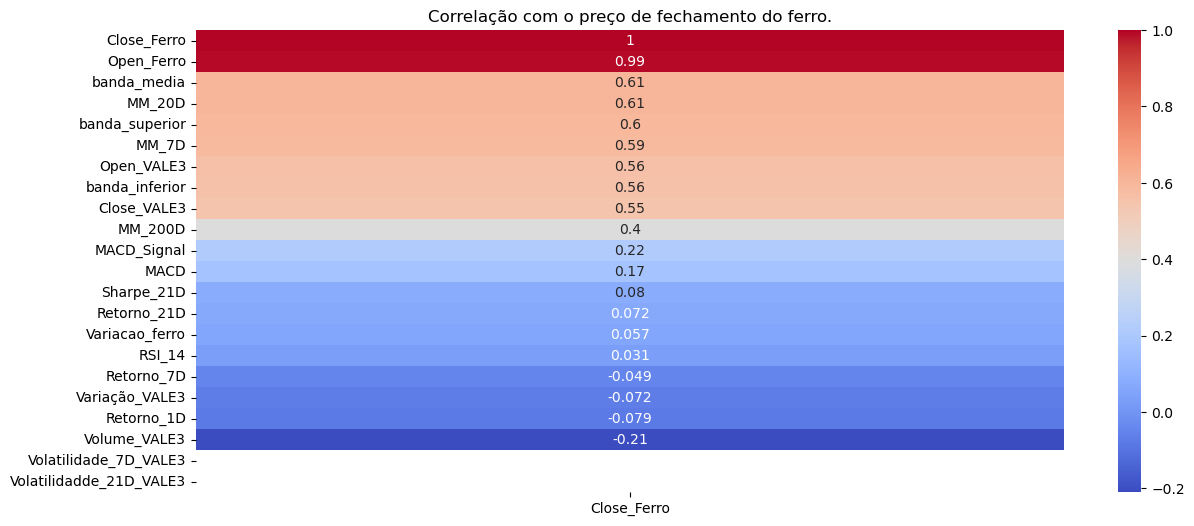

In [20]:
plt.figure(figsize=(14,6))

corr_matriz2 = X_train.corr()
sns.heatmap(corr_matriz2[['Close_Ferro']].sort_values(by='Close_Ferro', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title('Correlação com o preço de fechamento do ferro.')
plt.show()

* Agora podemos implementar o modelo SARIMA com as varáveis mais correlacionadas com Close_Ferro:

In [22]:
# SARIMA com variável exógena (preço do minério de ferro):
modelo_sarima = SARIMAX(
    endog = y_train,
    exog = X_train[['Close_Ferro', 'MM_20D', 'Close_VALE3', 'Open_VALE3', 'MM_200D', 'MM_7D']],
    order = (2, 1, 2),
    seasonal_order = (1, 1, 1, 5),
    enforce_stationarity = False,
    enforce_invertibility = False
)

# Treinar o modelo:
results_sarima = modelo_sarima.fit(disp=False)

# Previsão na validação (com dados exógenos):
sarima_val_pred = results_sarima.get_forecast(
    steps=len(y_val),
    exog = X_val[['Close_Ferro', 'MM_20D', 'Close_VALE3', 'Open_VALE3', 'MM_200D', 'MM_7D']]
).predicted_mean

# Avaliação
sarima_mae = mean_absolute_error(y_val, sarima_val_pred)
print(f"SARIMA MAE: {sarima_mae:.4f}")
sarima_mape = mean_absolute_percentage_error(y_val, sarima_val_pred)
print(f"SARIMA MAPE: {sarima_mape:.4f}")

SARIMA MAE: 4.2399
SARIMA MAPE: 0.0736
